<center>
    <h1 style="color:rgb(40, 0, 77);font-size:40px"><b>NIDS baseado em machine learning - Segurança e Auditoria de Sistemas</b></h1>
</center>

<center><img src="seguranca.jpg" width=800/>

# **Descrição do Problema**

<p>Este Jupyter Notebook será utilizado para solução do problema proposto no projeto da disciplina de Segurança e Auditoria de Sistemas, UTFPR-CP. O objetivo do trabalho é desenvolver um modelo de machine learning que seja capaz de classificar se um fluxo de pacotes em uma rede representa uma ameaça ou não, e, caso represente, qual o tipo específico de ameaça, no caso, um Network Intrusion Detection System (NIDS). O dataset utilizado será o NSL-KDD, disponibilizado pela University of New Brunswick (UNB).</p>

Com isso em mente, ao longo deste notebook serão desenvolvidas as tarefas:
- Análise exploratória, limpeza e manipulação dos dados;
- Criação de gráficos para visualização dos dados;
- Construção de modelos preditivos, buscando testar diferentes algoritmos de classificação.

# **Importação das bibliotecas**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, roc_curve
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline

# **Análise Exploratória, limpeza e manipulação dos dados**

In [2]:
#carregando os dados de treino
dados_treino = pd.read_csv("dados/KDDTrain+.txt", header=None)
col_names = ["duration","protocol type","service","flag","src_bytes","dst_bytes",
             "land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
             "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count",
             "serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
             "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
             "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack type","attack level"]
dados_treino.columns = col_names
dados_treino.head(10)

,duration,protocol type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack type,attack level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
9,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


In [3]:
dados_treino.shape

(125973, 43)

In [4]:
#verificando se há valores nulos
dados_treino.isnull().sum()[dados_treino.isnull().sum() > 0]

Series([], dtype: int64)

In [5]:
#resumo estatístico básico dos atributos
dados_treino.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack level
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [6]:
#verificando se há valores duplicados
dados_treino.duplicated().sum()

0

In [7]:
#quantidade de registros por tipo de ataque
dados_treino["attack type"].value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack type, dtype: int64

In [8]:
#dicionario para mapear os tipos de ataque - incluindo os que estão no dataset de teste
#0 - normal
#1 - DoS
#2 - Probe
#3 - U2R
#4 - R2L
dic_ataques = {
    "normal": 0,
    "apache2": 1,
    "back": 1,
    "land": 1,
    "neptune": 1,
    "mailbomb": 1,
    "pod": 1,
    "processtable": 1,
    "smurf": 1,
    "teardrop": 1,
    "udpstorm": 1,
    "worm": 1,
    "ipsweep": 2,
    "mscan": 2,
    "nmap": 2,
    "portsweep": 2,
    "saint": 2,
    "satan": 2,
    "buffer_overflow": 3,
    "loadmodule": 3,
    "perl": 3,
    "ps": 3,
    "rootkit": 3,
    "sqlattack": 3,
    "xterm": 3,
    "ftp_write": 4,
    "guess_passwd": 4,
    "httptunnel": 4,
    "imap": 4,
    "multihop": 4,
    "named": 4,
    "phf": 4,
    "sendmail": 4,
    "snmpgetattack": 4,
    "spy": 4,
    "snmpguess": 4,
    "warezclient": 4,
    "warezmaster": 4,
    "xlock": 4,
    "xsnoop": 4
}

In [9]:
#mapeando os ataques e verificando a contagem
dados_treino["attack type"] = dados_treino["attack type"].map(dic_ataques)
dados_treino["attack type"].value_counts()

0    67343
1    45927
2    11656
4      995
3       52
Name: attack type, dtype: int64

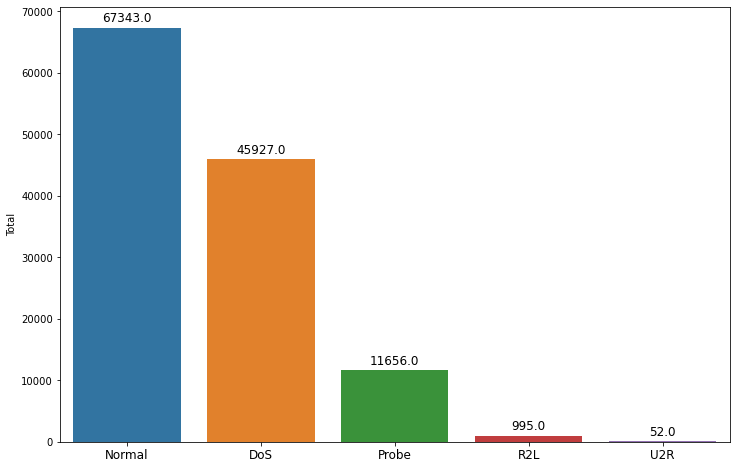

In [10]:
plt.figure(figsize=(12,8))
splot = sns.barplot(x = ["Normal","DoS","Probe","R2L","U2R"], y = dados_treino["attack type"].value_counts())
plt.ylabel("Total")
plt.xticks(fontsize = 12)
for p in splot.patches:
    splot.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', fontsize = 12)

In [11]:
#contagem de valores distintos por coluna
dados_treino.nunique()

duration                       2981
protocol type                     3
service                          70
flag                             11
src_bytes                      3341
dst_bytes                      9326
land                              2
wrong_fragment                    3
urgent                            4
hot                              28
num_failed_logins                 6
logged_in                         2
num_compromised                  88
root_shell                        2
su_attempted                      3
num_root                         82
num_file_creations               35
num_shells                        3
num_access_files                 10
num_outbound_cmds                 1
is_host_login                     2
is_guest_login                    2
count                           512
srv_count                       509
serror_rate                      89
srv_serror_rate                  86
rerror_rate                      82
srv_rerror_rate             

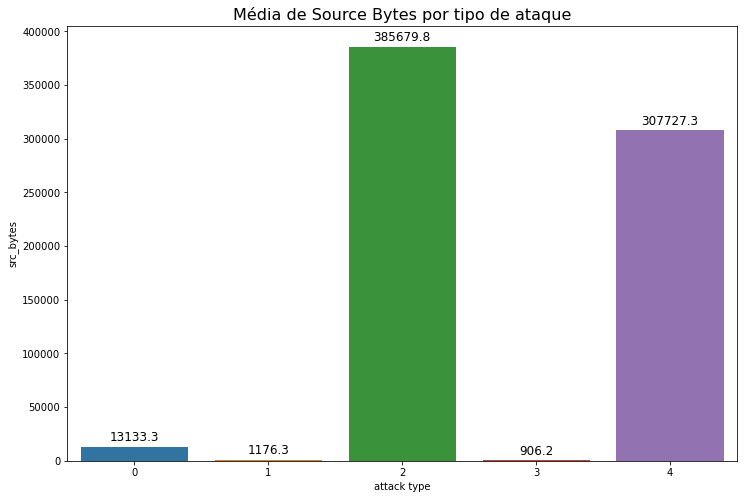

In [12]:
plt.figure(figsize=(12,8))
plt.title("Média de Source Bytes por tipo de ataque", fontsize = 16)
splot = sns.barplot(x = dados_treino.groupby("attack type")["src_bytes"].mean().index, y = dados_treino.groupby("attack type")["src_bytes"].mean())
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', fontsize = 12)

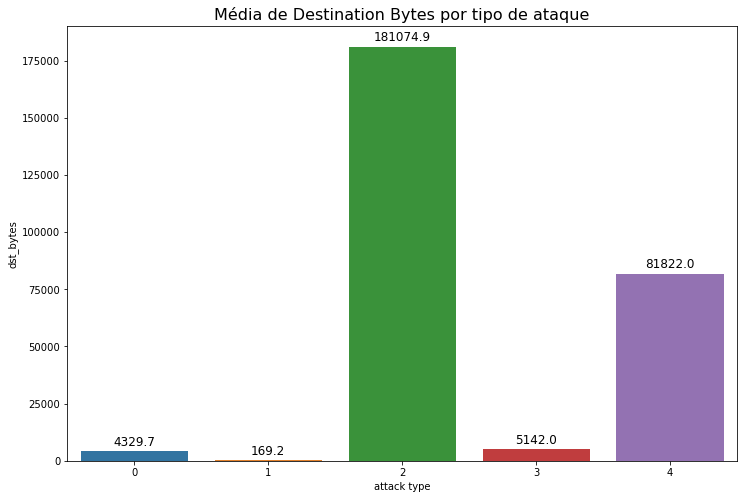

In [13]:
plt.figure(figsize=(12,8))
plt.title("Média de Destination Bytes por tipo de ataque", fontsize = 16)
splot = sns.barplot(x = dados_treino.groupby("attack type")["dst_bytes"].mean().index, y = dados_treino.groupby("attack type")["dst_bytes"].mean())
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', fontsize = 12)

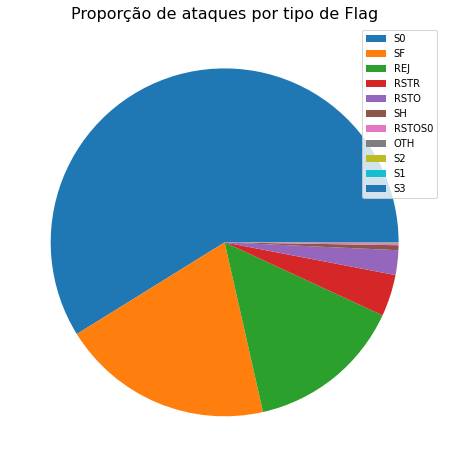

In [14]:
plt.figure(figsize=(12,8))
plt.title("Proporção de ataques por tipo de Flag", fontsize = 16)
plt.pie(dados_treino[dados_treino["attack type"] != 0]["flag"].value_counts())
plt.legend(dados_treino[dados_treino["attack type"] != 0]["flag"].value_counts().index, loc='upper right')

In [15]:
#porcentagem representativa da proporção de ataques por flag
(dados_treino[dados_treino["attack type"] != 0]["flag"].value_counts() / dados_treino["flag"].value_counts()) * 100

OTH        76.086957
REJ        76.025995
RSTO       85.979513
RSTOS0    100.000000
RSTR       93.969434
S0         98.984247
S1          1.095890
S2          6.299213
S3          8.163265
SF         15.413970
SH         99.261993
Name: flag, dtype: float64

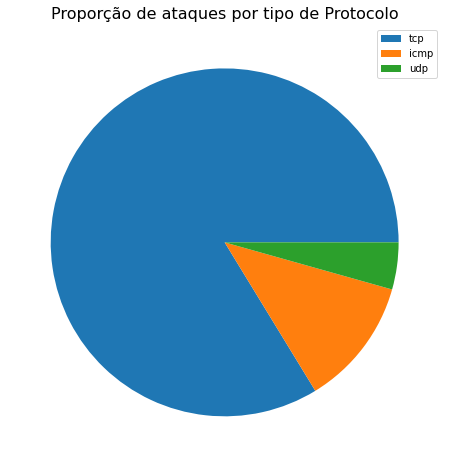

In [16]:
plt.figure(figsize=(12,8))
plt.title("Proporção de ataques por tipo de Protocolo", fontsize = 16)
plt.pie(dados_treino[dados_treino["attack type"] != 0]["protocol type"].value_counts())
plt.legend(dados_treino[dados_treino["attack type"] != 0]["protocol type"].value_counts().index, loc='upper right')

In [17]:
#porcentagem representativa da proporção de ataques por protocolo
(dados_treino[dados_treino["attack type"] != 0]["protocol type"].value_counts() / dados_treino["protocol type"].value_counts()) * 100

icmp    84.211796
tcp     47.803562
udp     17.067965
Name: protocol type, dtype: float64

In [18]:
print("Número médio de conexões com o mesmo host de destino que a conexão atual nos últimos dois segundos")
print("Sem ataque: ",dados_treino[dados_treino["attack type"] == 0]["count"].mean())
print("Com ataque: ",dados_treino[dados_treino["attack type"] != 0]["count"].mean())

Número médio de conexões com o mesmo host de destino que a conexão atual nos últimos dois segundos
Sem ataque:  22.517945443475938
Com ataque:  154.8499914719427


In [19]:
print("A porcentagem de conexões que foram para o mesmo serviço, entre as conexões agregadas em contagem")
print("Sem ataque: ",dados_treino[dados_treino["attack type"] == 0]["same_srv_rate"].mean() * 100)
print("Com ataque: ",dados_treino[dados_treino["attack type"] != 0]["same_srv_rate"].mean() * 100)

A porcentagem de conexões que foram para o mesmo serviço, entre as conexões agregadas em contagem
Sem ataque:  96.9360141365838
Com ataque:  30.66590482688391


In [20]:
print("A porcentagem média de conexões que foram para serviços diferentes, entre as conexões agregadas na contagem")
print("Sem ataque: ",dados_treino[dados_treino["attack type"] == 0]["diff_srv_rate"].mean() * 100)
print("Com ataque: ",dados_treino[dados_treino["attack type"] != 0]["diff_srv_rate"].mean() * 100)

A porcentagem média de conexões que foram para serviços diferentes, entre as conexões agregadas na contagem
Sem ataque:  2.878784728925027
Com ataque:  10.240951731199127


In [21]:
#propensão de serviços estarem relacionados com ataque
#44 estão 100% ligados a ataques
services_p = (dados_treino[dados_treino["attack type"] != 0]["service"].value_counts() / dados_treino["service"].value_counts()) * 100
services_p.value_counts()

100.000000    44
0.534759       1
99.536321      1
88.379205      1
37.500000      1
61.028474      1
98.392283      1
3.883495       1
93.846154      1
95.506338      1
29.545455      1
40.261528      1
5.674550       1
8.219178       1
27.346939      1
47.662486      1
69.156763      1
93.825154      1
89.162669      1
0.099524       1
93.321617      1
75.287958      1
0.498339       1
Name: service, dtype: int64

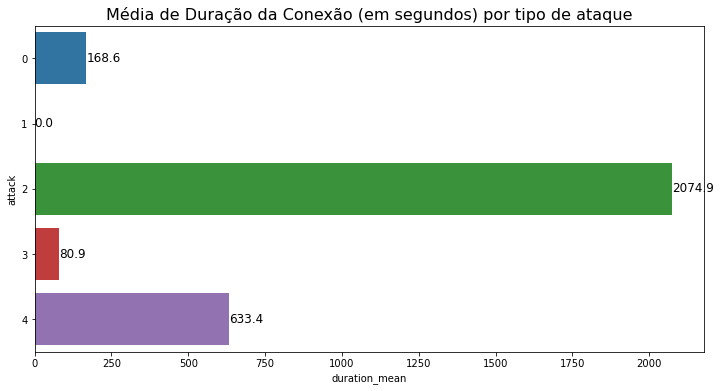

In [22]:
df_duration = pd.DataFrame({"attack": [str(label) for label in dados_treino.groupby("attack type")["duration"].mean().index],
                            "duration_mean": dados_treino.groupby("attack type")["duration"].mean()})
plt.figure(figsize=(12,6))
plt.title("Média de Duração da Conexão (em segundos) por tipo de ataque", fontsize = 16)
splot = sns.barplot(x='duration_mean', y='attack', data=df_duration)
for p in splot.patches:
    splot.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width(),p.get_y() + p.get_height()/1.5), 
                   ha = 'left', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', fontsize = 12)

# **Feature Engineering**

In [23]:
#trabalhando com a seleção de atributos
#primeiramente, aplicar a técnica de mutual information
#para isso, os dados categóricos devem ser convertidos para numéricos
treino_copy = dados_treino.copy()
treino_copy.pop("attack level")
target_copy = treino_copy.pop("attack type")

print(treino_copy.select_dtypes("object"))
for column in treino_copy.select_dtypes("object"):
    treino_copy[column], _ = treino_copy[column].factorize()

       protocol type   service flag
0                tcp  ftp_data   SF
1                udp     other   SF
2                tcp   private   S0
3                tcp      http   SF
4                tcp      http   SF
...              ...       ...  ...
125968           tcp   private   S0
125969           udp   private   SF
125970           tcp      smtp   SF
125971           tcp    klogin   S0
125972           tcp  ftp_data   SF

[125973 rows x 3 columns]


In [24]:
#função para gerar os MI scores
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [25]:
mi_scores = make_mi_scores(treino_copy, target_copy)

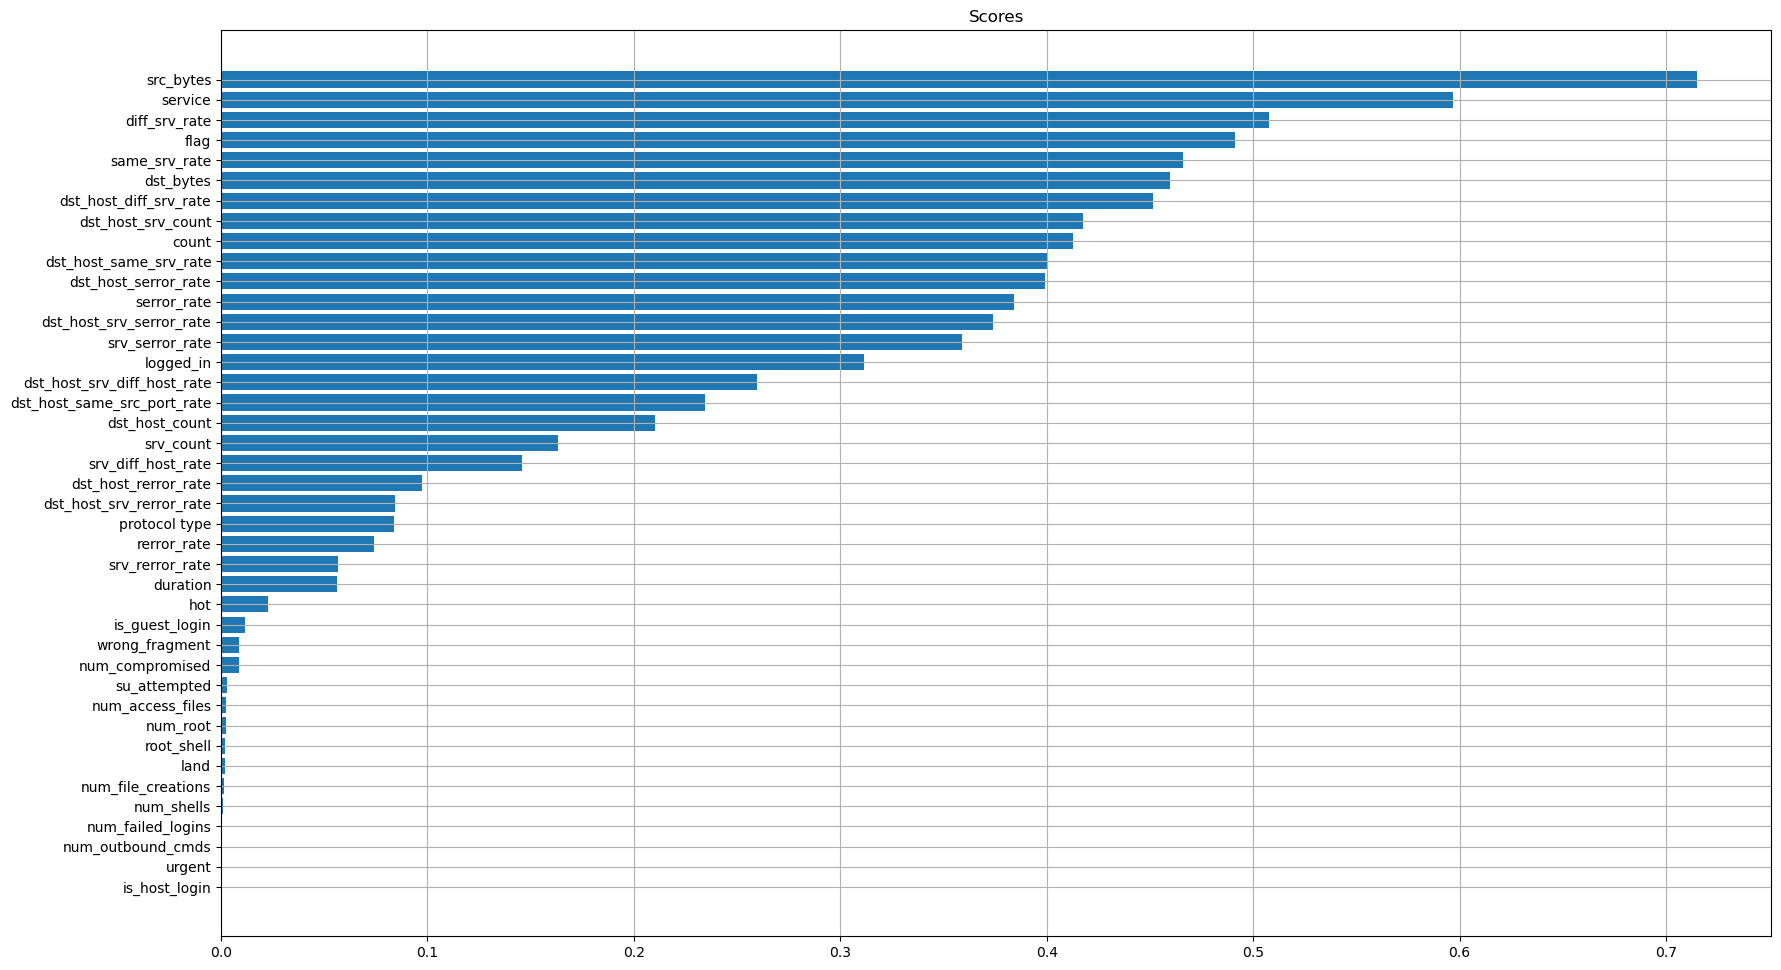

In [26]:
def plot_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Scores")
    plt.grid()

plt.figure(dpi=100, figsize=(20, 12))
plot_scores(mi_scores)

In [27]:
#agora gerar a importancia de features para um modelo de machine learning
#neste caso, vai ser utilizado o random forest classifier do sklearn
#a estratégia é a mesma adotada para mutual information
def rf_feature_importance(X,y):
    RFC = RandomForestClassifier()
    RFC.fit(X,y)
    importance = RFC.feature_importances_
    importance = pd.Series(importance, name="Importance Scores", index=X.columns)
    importance = importance.sort_values(ascending=False)
    return importance

In [28]:
rf_importance = rf_feature_importance(treino_copy, target_copy)

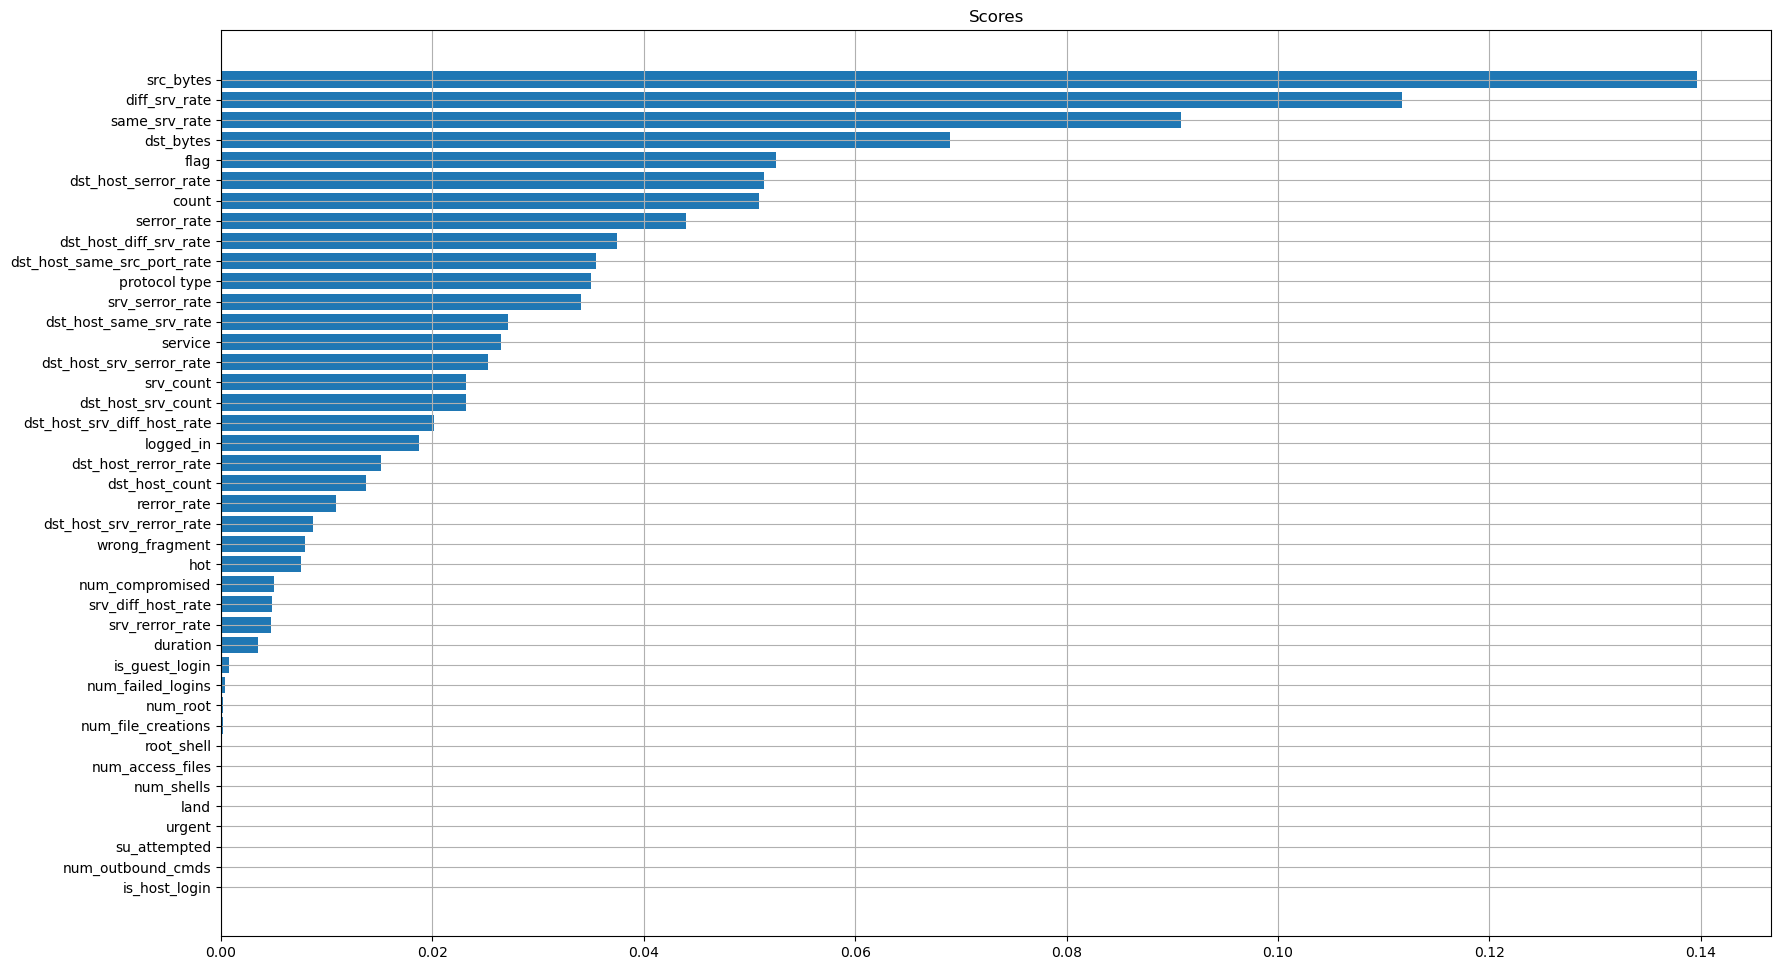

In [29]:
plt.figure(dpi=100, figsize=(20, 12))
plot_scores(rf_importance)

## **Feature Selection**

In [30]:
#dados de treino
atributos_selecionados = ["src_bytes","flag","protocol type","count","dst_bytes","duration",
                          "diff_srv_rate","same_srv_rate"]
x_train = dados_treino.loc[:,atributos_selecionados]
y_train = dados_treino["attack type"]

In [31]:
#dados de teste
dados_teste = pd.read_csv("dados/KDDTest+.txt", header=None)
dados_teste.columns = col_names

dados_teste["attack type"] = dados_teste["attack type"].map(dic_ataques)
x_test = dados_teste.loc[:,atributos_selecionados]
y_test = dados_teste["attack type"]

In [32]:
#criando os processors
categorical_cols = [column for column in x_train.select_dtypes("object")]
numerical_cols = list(set(atributos_selecionados) - set(categorical_cols))

numerical_transformer = MinMaxScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore',sparse=False)

preprocessor = ColumnTransformer(transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
            ])

# **Criação dos Modelos**

In [33]:
#Serão construídos os modelos a partir dos algoritmos de classificação:
#decision tree, Random Forest e support vector machines
tree_model = DecisionTreeClassifier(random_state=0)
rf_model = RandomForestClassifier(random_state=0)
svm_model = SVC(random_state=0)

In [34]:
#criando os pipelines
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', tree_model)])
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', rf_model)])
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', svm_model)])

In [35]:
#treinando os modelos e gerando as previsões
np.random.seed(1234)
tree_pipeline.fit(x_train,y_train)
tree_predictions = tree_pipeline.predict(x_test)

np.random.seed(1234)
rf_pipeline.fit(x_train,y_train)
rf_predictions = rf_pipeline.predict(x_test)

np.random.seed(1234)
svm_pipeline.fit(x_train,y_train)
svm_predictions = svm_pipeline.predict(x_test)

In [36]:
#métricas de avaliação
print("Resultados Decision Tree:")
print(accuracy_score(y_test, tree_predictions))
print(precision_recall_fscore_support(y_test, tree_predictions))
print(classification_report(y_test, tree_predictions))

Resultados Decision Tree:
0.7640170333569908
(array([0.67040295, 0.96513496, 0.84536585, 0.92307692, 0.06756757]), array([0.97312326, 0.80522788, 0.71581991, 0.35820896, 0.0034662 ]), array([0.79388415, 0.87795966, 0.77521807, 0.51612903, 0.00659413]), array([9711, 7460, 2421,   67, 2885]))
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.81      0.88      7460
           2       0.85      0.72      0.78      2421
           3       0.92      0.36      0.52        67
           4       0.07      0.00      0.01      2885

    accuracy                           0.76     22544
   macro avg       0.69      0.57      0.59     22544
weighted avg       0.71      0.76      0.72     22544



In [37]:
print("Resultados Random Forest:")
print(accuracy_score(y_test, rf_predictions))
print(precision_recall_fscore_support(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Resultados Random Forest:
0.7696061036195884
(array([0.66850516, 0.96665618, 0.86444886, 1.        , 0.19230769]), array([0.97353517, 0.82386059, 0.71912433, 0.05970149, 0.0017331 ]), array([0.79268855, 0.88956434, 0.78511838, 0.11267606, 0.00343525]), array([9711, 7460, 2421,   67, 2885]))
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.82      0.89      7460
           2       0.86      0.72      0.79      2421
           3       1.00      0.06      0.11        67
           4       0.19      0.00      0.00      2885

    accuracy                           0.77     22544
   macro avg       0.74      0.52      0.52     22544
weighted avg       0.73      0.77      0.72     22544



In [38]:
print("Resultados Support Vector Machines:")
print(accuracy_score(y_test, svm_predictions))
print(precision_recall_fscore_support(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))

Resultados Support Vector Machines:
0.7416607523066004
(array([0.66433811, 0.96953689, 0.66823529, 0.        , 0.        ]), array([0.97930182, 0.73806971, 0.70384139, 0.        , 0.        ]), array([0.79164239, 0.83811553, 0.68557634, 0.        , 0.        ]), array([9711, 7460, 2421,   67, 2885]))
              precision    recall  f1-score   support

           0       0.66      0.98      0.79      9711
           1       0.97      0.74      0.84      7460
           2       0.67      0.70      0.69      2421
           3       0.00      0.00      0.00        67
           4       0.00      0.00      0.00      2885

    accuracy                           0.74     22544
   macro avg       0.46      0.48      0.46     22544
weighted avg       0.68      0.74      0.69     22544



# **Classificação binária**

In [39]:
#transformando todos os ataques para 1 em y_train e y_test
y_train_binary = pd.Series(y_train.map(lambda x: 0 if x == 0 else 1))
y_test_binary = pd.Series(y_test.map(lambda x: 0 if x == 0 else 1))

In [66]:
tree_binary_model = DecisionTreeClassifier(random_state=0)
rf_binary_model = RandomForestClassifier(random_state=0)
svm_binary_model = SVC(random_state=0, probability=True)

In [67]:
#criando os pipelines
tree_binary_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', tree_binary_model)])
rf_binary_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', rf_binary_model)])
svm_binary_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', svm_binary_model)])

In [68]:
#treinando os modelos e gerando as previsões
np.random.seed(1234)
tree_binary_pipeline.fit(x_train,y_train_binary)
tree_predictions_binary = tree_binary_pipeline.predict(x_test)

np.random.seed(1234)
rf_binary_pipeline.fit(x_train,y_train_binary)
rf_predictions_binary = rf_binary_pipeline.predict(x_test)

np.random.seed(1234)
svm_binary_pipeline.fit(x_train,y_train_binary)
svm_predictions_binary = svm_binary_pipeline.predict(x_test)

In [69]:
#métricas de avaliação
print("Resultados Decision Tree:")
print(accuracy_score(y_test_binary, tree_predictions_binary))
print(precision_recall_fscore_support(y_test_binary, tree_predictions_binary))
print(classification_report(y_test_binary, tree_predictions_binary))

Resultados Decision Tree:
0.7833126330731015
(array([0.67157281, 0.96863208]), array([0.97260838, 0.64006857]), array([0.79453207, 0.77079717]), array([ 9711, 12833]))
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.64      0.77     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



In [70]:
print("Resultados Random Forest:")
print(accuracy_score(y_test_binary, rf_predictions_binary))
print(precision_recall_fscore_support(y_test_binary, rf_predictions_binary))
print(classification_report(y_test_binary, rf_predictions_binary))

Resultados Random Forest:
0.7843328601845281
(array([0.67240276, 0.96993279]), array([0.97374112, 0.64100366]), array([0.79549087, 0.77188702]), array([ 9711, 12833]))
              precision    recall  f1-score   support

           0       0.67      0.97      0.80      9711
           1       0.97      0.64      0.77     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



In [71]:
print("Resultados Support Vector Machines:")
print(accuracy_score(y_test_binary, svm_predictions_binary))
print(precision_recall_fscore_support(y_test_binary, svm_predictions_binary))
print(classification_report(y_test_binary, svm_predictions_binary))

Resultados Support Vector Machines:
0.7796309439318666
(array([0.66622275, 0.97511176]), array([0.97878694, 0.62892543]), array([0.79281008, 0.7646613 ]), array([ 9711, 12833]))
              precision    recall  f1-score   support

           0       0.67      0.98      0.79      9711
           1       0.98      0.63      0.76     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.78     22544
weighted avg       0.84      0.78      0.78     22544



# **Binarização dos resultados da classificação não binária para testes**

In [46]:
tree_predictions_convertido = pd.Series(tree_predictions).map(lambda x: 0 if x == 0 else 1).to_numpy()
rf_predictions_convertido = pd.Series(rf_predictions).map(lambda x: 0 if x == 0 else 1).to_numpy()
svm_predictions_convertido = pd.Series(svm_predictions).map(lambda x: 0 if x == 0 else 1).to_numpy()

In [47]:
#métricas de avaliação
print("Resultados Decision Tree:")
print(accuracy_score(y_test_binary, tree_predictions_convertido))
print(precision_recall_fscore_support(y_test_binary, tree_predictions_convertido))
print(classification_report(y_test_binary, tree_predictions_convertido))

Resultados Decision Tree:
0.7823367636621718
(array([0.67040295, 0.96910511]), array([0.97312326, 0.63796462]), array([0.79388415, 0.76941873]), array([ 9711, 12833]))
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.64      0.77     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



In [48]:
print("Resultados Random Forest:")
print(accuracy_score(y_test_binary, rf_predictions_convertido))
print(precision_recall_fscore_support(y_test_binary, rf_predictions_convertido))
print(classification_report(y_test_binary, rf_predictions_convertido))

Resultados Random Forest:
0.7806511710432931
(array([0.66850516, 0.96941204]), array([0.97353517, 0.63469181]), array([0.79268855, 0.76712974]), array([ 9711, 12833]))
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.63      0.77     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.78     22544
weighted avg       0.84      0.78      0.78     22544



In [49]:
print("Resultados Support Vector Machines:")
print(accuracy_score(y_test_binary, svm_predictions_convertido))
print(precision_recall_fscore_support(y_test_binary, svm_predictions_convertido))
print(classification_report(y_test_binary, svm_predictions_convertido))

Resultados Support Vector Machines:
0.7779453513129879
(array([0.66433811, 0.97557419]), array([0.97930182, 0.62557469]), array([0.79164239, 0.76232077]), array([ 9711, 12833]))
              precision    recall  f1-score   support

           0       0.66      0.98      0.79      9711
           1       0.98      0.63      0.76     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.78     22544
weighted avg       0.84      0.78      0.77     22544



## **Salvando os modelos**

In [72]:
pickle.dump(tree_pipeline, open("models/tree_pipeline.sav", 'wb'))
pickle.dump(rf_pipeline, open("models/rf_pipeline.sav", 'wb'))
pickle.dump(svm_pipeline, open("models/svm_pipeline.sav", 'wb'))
pickle.dump(tree_binary_pipeline, open("models/tree_binary_pipeline.sav", 'wb'))
pickle.dump(rf_binary_pipeline, open("models/rf_binary_pipeline.sav", 'wb'))
pickle.dump(svm_binary_pipeline, open("models/svm_binary_pipeline.sav", 'wb'))

## **Plotando gráficos de AUC-ROC da classificação binária**

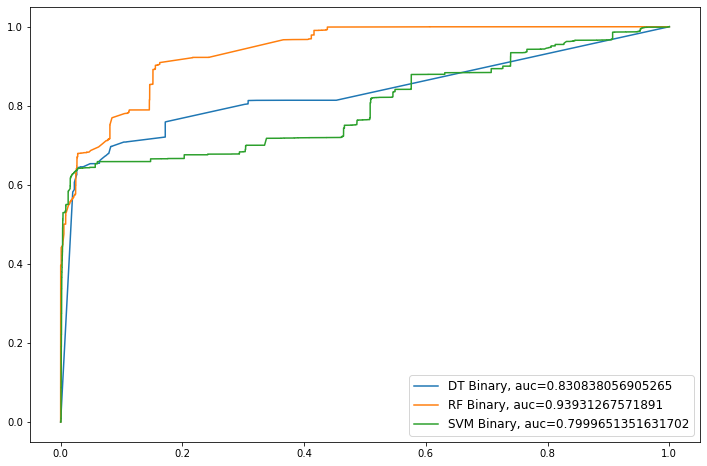

In [73]:
y_prob_tree_b = tree_binary_pipeline.predict_proba(x_test)[::,1]
y_prob_rf_b = rf_binary_pipeline.predict_proba(x_test)[::,1]
y_prob_svm_b = svm_binary_pipeline.predict_proba(x_test)[::,1]

fpr1, tpr1, _ = roc_curve(y_test_binary, y_prob_tree_b)
fpr2, tpr2, _ = roc_curve(y_test_binary, y_prob_rf_b)
fpr3, tpr3, _ = roc_curve(y_test_binary, y_prob_svm_b)

auc1 = roc_auc_score(y_test_binary, y_prob_tree_b)
auc2 = roc_auc_score(y_test_binary, y_prob_rf_b)
auc3 = roc_auc_score(y_test_binary, y_prob_svm_b)

plt.figure(figsize=(12, 8))
plt.plot(fpr1,tpr1,label="DT Binary, auc="+str(auc1))
plt.plot(fpr2,tpr2,label="RF Binary, auc="+str(auc2))
plt.plot(fpr3,tpr3,label="SVM Binary, auc="+str(auc3))

plt.legend(loc=4, fontsize=12)
plt.show()